## AUTOMATIC QUESTIONS & ANSWERING GENERATION


**Question answering tasks** return an answer given a question. There are two common forms of question answering:


*   **Extractive**: extract the answer from the given context.
*   **Abstractive**: generate an answer from the context that correctly answers the question.








**Question Answering models** can retrieve the answer to a question from a given text, which is useful for searching for an answer in a document. Some question answering models can generate answers without context!

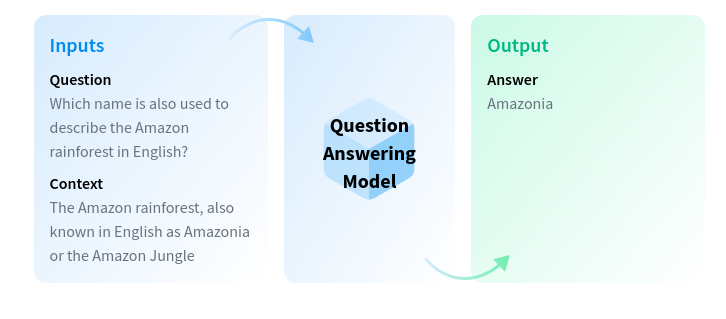

### Task Variants
There are different QA variants based on the inputs and outputs:


*   **Extractive QA**: The model extracts the answer from a context. The context here could be a provided text, a table or even HTML! This is usually solved with BERT-like models.
*   **Open Generative QA**: The model generates free text directly based on the context.


*   **Closed Generative QA**: In this case, no context is provided. The answer is completely generated by a model.

## Section I: Closed Generative QA

In this section, we show how to automatically retrieve suitable response to customer questions from FAQs with a purpose of aswering user's queries by automatically retrieving the closed question and answer from FAQs when appropriate.

We will use a sample datasets extracted from Stackoverflow for this task.

**The approach is as follows**: for a given query, find the FAQ question that is closest in meaning to the user query and display it to the user. For this, we need know more on how to compute **semantic similarity** between two sentences.

To do so, we will convert each sentence(user query, FAQ question) into a vector and use the cosine similarity between vectors to come up with a distance measure between sentences that indicates how similar they are in meaning ([details](https://nlp.town/blog/sentence-similarity/#:~:text=The%20easiest%20way%20of%20estimating,cosine%20between%20the%20resulting%20embeddings.))

#### Installation and setup
You need to install Numpy, scikit-learn, gensim, nltk (using conda). 
Before exploring the data using various visualization tools, we import it from our computer (or drive)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/kmerai

/content/drive/MyDrive/kmerai


In [ ]:
#we import our librairies
import pandas as pd
import numpy as np
import re
import gensim
import pprint
import sklearn

In [ ]:
#load and examine the dataset, rename columns to questions and answers
data_link= 'https://colab.research.google.com/drive/1S3r2hcwWfeLABciAVANnYUgliRHL5DPW?usp=sharing'
df = pd.read_csv(data_link)

df.columns = ["id","questions", "context","answers"]
df.drop('id', axis=1, inplace=True)
df.drop('context', axis=1, inplace=True)

In [ ]:
df

,questions,answers
0,"What does the ""yield"" keyword do?",It's not only about the technical finesse on h...
1,"What does if __name__ == ""__main__"": do?","Just for the record - what is ""main"": docs.pyt..."
2,Does Python have a ternary conditional operator?,In the Python 3.0 official documentation refer...
3,What are metaclasses in Python?,It appears that in Django models.Model it does...
4,How do I check whether a file exists without e...,To check whether a Path object exists independ...
...,...,...
894,How to read a text file from resources in Kotlin?,"For me this didn't work, I had to change it to..."
895,Android Room - Select query with LIKE,work even with kotlin bug: youtrack.jetbrains....
896,What is out keyword in kotlin,"Great explanation, straight to the point with ..."
897,Unresolved reference: kotlinx,"My solution was completely different, I remove..."


## Preprocessing

In [ ]:
#we are performing the following preprocessing:
# -Removing all characters that are not alpha numeric
# -Removing stopwords commonly used words susch as 'a', 'to', 'in' ...that do not contribute to the semantic siilarity between two sentences
# we apply the preprocessing for both the questions and the user query sentence
# Note that we have an option to not perform stopword removal because some of the later model such as BERT work well without stopword removal

from gensim.parsing.preprocessing import remove_stopwords

def clean_sentence (sentence,stopwords=False):

  sentence =  sentence.lower().strip()
  sentence = re.sub(r'[^a-z0-9\s]', '', sentence)

  if stopwords:
    sentence = remove_stopwords(sentence)
  
  return sentence

#now we clean our sentences
def get_cleaned_sentences(df,stopwords=False):
  sents = df[["questions"]];
  cleaned_sentences = []

  for index, row in df.iterrows():
    cleaned = clean_sentence(row["questions"],stopwords);
    cleaned_sentences.append(cleaned)
  return cleaned_sentences

cleaned_sentences = get_cleaned_sentences(df, stopwords=True)
print(cleaned_sentences)

print("\n")

cleaned_sentences_with_stopwords = get_cleaned_sentences(df, stopwords=False)
print(cleaned_sentences_with_stopwords)


['yield keyword', 'main', 'python ternary conditional operator', 'metaclasses python', 'check file exists exceptions', 'merge dictionaries single expression union dictionaries', 'execute program command', 'safely create nested directory', 'accessing index loops', 'flat list list lists', 'difference staticmethod classmethod', 'understanding slicing', 'finding index item list', 'iterating dictionaries loops', 'global variables function', 'python string contains substring method', 'current time', 'catch multiple exceptions line block', 'list files directory', 'sort dictionary value', 'iterate rows dataframe pandas', 'difference str repr', 'add new keys dictionary', 'convert bytes string', 'copy files', 'concatenate lists python', 'check list', 'initpy', 'difference pythons list methods append extend', 'astonishment mutable default argument', 'pass variable reference', 'time delay python duplicate', 'clone list doesnt change unexpectedly assignment', 'function decorators chain', 'understan

There are differents techniques of converting sentences into vector(sentences Embedding) such as: 

*   Bag of Words
*   Word2vec-Skipgram


*   Glove
*   BERT





### Bag of words
A bag of words is a representation of text that describes the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order. It is called a “bag” of words because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document. ([details](https://www.mygreatlearning.com/blog/bag-of-words/))

In [ ]:

sentences = cleaned_sentences_with_stopwords

#split the sentences by white space
sentence_words = [[word for word in document.split()]
                   for document in sentences]

from gensim import corpora

dictionary = corpora.Dictionary(sentence_words)
for key, value in dictionary.items():
  print(key, ' : ', value)

#we create a bag of word corpus which will give us a sparse representation of each sentence
bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]
for sent,embedding in zip(sentences,bow_corpus):
  print(sent)
  print(embedding)

#we do the same for the user query
question_orig = "how to copy files using command lines?"
question = clean_sentence(question_orig,stopwords = False)
question_embedding = dictionary.doc2bow(question.split())

print("\n\n",question,"\n",question_embedding)

0  :  do
1  :  does
2  :  keyword
3  :  the
4  :  what
5  :  yield
6  :  if
7  :  main
8  :  name
9  :  a
10  :  conditional
11  :  have
12  :  operator
13  :  python
14  :  ternary
15  :  are
16  :  in
17  :  metaclasses
18  :  check
19  :  exceptions
20  :  exists
21  :  file
22  :  how
23  :  i
24  :  whether
25  :  without
26  :  dictionaries
27  :  expression
28  :  merge
29  :  of
30  :  single
31  :  take
32  :  two
33  :  union
34  :  call
35  :  command
36  :  execute
37  :  or
38  :  program
39  :  system
40  :  can
41  :  create
42  :  directory
43  :  nested
44  :  safely
45  :  accessing
46  :  for
47  :  index
48  :  loops
49  :  flat
50  :  list
51  :  lists
52  :  make
53  :  out
54  :  to
55  :  and
56  :  between
57  :  classmethod
58  :  difference
59  :  staticmethod
60  :  slicing
61  :  understanding
62  :  an
63  :  finding
64  :  item
65  :  iterating
66  :  over
67  :  using
68  :  function
69  :  global
70  :  variables
71  :  contains
72  :  method
73  :  str

We have obtained a vector in the form of bag of word for the questions and for the user querry

In [ ]:
#we now want to know what is the closest question to the user query using the cosine similarity by doing a vector comparison
from sklearn.metrics.pairwise import cosine_similarity

def retriveAndPrintFAQAnswer (question_embedding, sentence_embeddings, FAQdf, sentences):
  max_sim = 1
  index_sim = 1
  for index, faq_embedding in enumerate(sentence_embeddings):
    sim = cosine_similarity(faq_embedding, question_embedding)[0][0]
    print(index, sim, sentences[index])
    if sim > max_sim:
      max_sim = sim
      index_sim = index

  print("\n")
  print("Questions:", question)
  print("\n")
  print("Retrieved:", FAQdf.iloc[index_sim,0])
  print(FAQdf.iloc[index_sim,1])

retriveAndPrintFAQAnswer(question_embedding, bow_corpus, df, sentences)

0 0.045407660918649985 what does the yield keyword do
1 0.045407660918649985 what does if name  main do
2 0.7384854939281259 does python have a ternary conditional operator
3 0.9801548125884953 what are metaclasses in python
4 0.045407660918649985 how do i check whether a file exists without exceptions
5 0.045407660918649985 how do i merge two dictionaries in a single expression take union of dictionaries
6 0.045407660918649985 how do i execute a program or call a system command
7 0.9978730208564015 how can i safely create a nested directory
8 0.9620639325477691 accessing the index in for loops
9 0.9850304671557043 how to make a flat list out of a list of lists
10 0.9996289197775032 difference between staticmethod and classmethod
11 0.9995865127385761 understanding slicing
12 0.9620639325477691 finding the index of an item in a list
13 0.9999756350866899 iterating over dictionaries using for loops
14 0.9978730208564015 using global variables in a function
15 0.7384854939281259 does pyt

### Word2vec -skipgram

It does better than the BAg of Word approach because they are  able to take into account semantic similarity of words based on context
You can find more details on the properties of Embeddings using Skipgram [ here](http://code.google.com/archive/p/word2vec/)

### Glove Embeddings
this is an alternative approach to build word embeddings using matrix factorization techniques on the word-word-occurance matrix (more details [here](https://nlp.stanford.edu/projects/glove/))

In [ ]:
#here we experiment with both the word2vec and the glove models
#these models are pretrained on a large volume of text

from gensim.models import Word2Vec
import gensim.downloader as api


glove_model = None
try:
  glove_model = gensim.models.KeyedVectors.load ("./glovemodel.mod")
  print("Loaded glove model")
except:
  glove_model = api.load('glove-twitter-25')#25(dimensions of the vector) glove embeddings
  glove_model.save("./glovemodel.mod")
  print("Saved glove model")

w2v_model = None

try:
  w2v_model = gensim.models.KeyedVectors.load("./w2vecmodel.mod")
  print("Loaded w2v model")
except:
  w2v_model = api.load('word2vec-google-news-300')#300 is the dimension of the vector
  w2v_model.save("./w2vecmodel.mod")
  print("Saved w2v model")
  

w2vec_embedding_size = len(w2v_model['computer'])
glove_embedding_size = len(glove_model['computer'])

Loaded glove model
Loaded w2v model


In [ ]:
#what if a particular word is not in the vocabulary?
#Answer: we return a vector=0 of that dimension

def getWordVec(word, model):
  samp=model['computer']
  vec=[0]*len(samp)
  try:
    vec=model[word]
  except:
    vec=[0]*len(samp)
  return (vec)

#we add all the vectors in a for loop to get the phraseEmbedding
def getPhraseEmbedding(phrase, embeddingmodel):
  samp=getWordVec('computer', embeddingmodel)
  vec=np.array([0]*len(samp))
  den=0
  for word in phrase.split():
    den=den+1
    vec=vec+np.array(getWordVec(word, embeddingmodel))
  return vec.reshape(1, -1)

In [ ]:
#with w2vec

sent_embeddings=[]
for sent in cleaned_sentences:
  sent_embeddings.append(getPhraseEmbedding(sent, w2v_model))

question_embedding =getPhraseEmbedding(question, w2v_model)

retriveAndPrintFAQAnswer(question_embedding, sent_embeddings, df, cleaned_sentences)

0 0.20242348113814512 yield keyword
1 0.07818428796053138 main
2 0.213185089664814 python ternary conditional operator
3 0.1489629836963294 metaclasses python
4 0.4874647343794717 check file exists exceptions
5 0.37205155802331247 merge dictionaries single expression union dictionaries
6 0.47273200917792196 execute program command
7 0.40268990142287786 safely create nested directory
8 0.3660873380677358 accessing index loops
9 0.2765866585251894 flat list list lists
10 0.13906418161634607 difference staticmethod classmethod
11 0.22969470937993994 understanding slicing
12 0.288403065119731 finding index item list
13 0.3834312780741872 iterating dictionaries loops
14 0.2939320463833694 global variables function
15 0.39160890440313734 python string contains substring method
16 0.237753932092226 current time
17 0.3515528743932001 catch multiple exceptions line block
18 0.5424928418400938 list files directory
19 0.4040632965055349 sort dictionary value
20 0.24976026190310524 iterate rows da

In [ ]:
#with Glove
sent_embeddings=[]
for sent in cleaned_sentences:
  sent_embeddings.append(getPhraseEmbedding(sent, glove_model))
question_embedding=getPhraseEmbedding(question, glove_model)

retriveAndPrintFAQAnswer(question_embedding,sent_embeddings,df,cleaned_sentences)

0 0.6870189259491012 yield keyword
1 0.4895637758667763 main
2 0.695856242946772 python ternary conditional operator
3 0.6018178016284814 metaclasses python
4 0.9247470410953579 check file exists exceptions
5 0.8732776050862264 merge dictionaries single expression union dictionaries
6 0.8146698951046606 execute program command
7 0.7551889818674841 safely create nested directory
8 0.7036866607840429 accessing index loops
9 0.9047902558737095 flat list list lists
10 0.827562648626401 difference staticmethod classmethod
11 0.6679946864373735 understanding slicing
12 0.9029922165039044 finding index item list
13 0.45778587432875034 iterating dictionaries loops
14 0.7595509422212771 global variables function
15 0.759915570100321 python string contains substring method
16 0.8746212265584838 current time
17 0.921741159597165 catch multiple exceptions line block
18 0.8334775198715435 list files directory
19 0.9021446302849259 sort dictionary value
20 0.38456311101807333 iterate rows dataframe 

### Section II: Open Generative QA

In this section we will show how to fine-tune **DistilBERT** on the **SQuAD** dataset for extractive question answering.

**BERT** based models instead of looking at words in isolation, are transformer based models which attemps to use the context of words to get embeddings

*   State of the Art deep learning based model that captures longer range context
*   Based on cepts Transformer architecture and masked Learning model



In [ ]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 325 kB 57.0 MB/s 
     |████████████████████████████████| 596 kB 52.7 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 880 kB 16.3 MB/s 
     |████████████████████████████████| 136 kB 19.2 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
     |████████████████████████████████| 212 kB 64.5 MB/s 
     |████████████████████████████████| 127 kB 50.0 MB/s 
     |████████████████████████████████| 271 kB 54.3 MB/s 
     |████████████████████████████████| 94 kB 1.6 MB/s 
     |████████████████████████████████| 144 kB 50.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0a67dc54bb60dc716e880f0a10655321206674ee047077f58874c63570e187dc
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d66029

Here we use the [Squad](https://rajpurkar.github.io/SQuAD-explorer/) Dataset

In [ ]:
#Load SQuAD dataset
from datasets import load_dataset

squad = load_dataset("squad")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [ ]:
squad["train"][0]

{'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']},
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'id': '5733be284776f41900661182',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'title': 'University_of_Notre_Dame'}

In [ ]:
# Make sure you have a GPU running
!nvidia-smi

Mon May  9 19:38:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install the latest release of Haystack in your own environment
#! pip install farm-haystack

# Install the latest master of Haystack
!pip install --upgrade pip
!pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab]

     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-f0oygxov/farm-haystack_efe5aa40b1fd427a8dd58eee6ca6a69a
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-install-f0oygxov/farm-haystack_efe5aa40b1fd427a8dd58eee6ca6a69a
  Resolved https://github.com/deepset-ai/haystack.git to commit 3d8bdf3cb69c5592518e9ca7c5274c3a551ea4a3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━

In [ ]:
!pip3 install farm-haystack

In [ ]:
from haystack.nodes import FARMReader
from haystack.utils import fetch_archive_from_http

In [ ]:
data_dir1 = squad['train']


In [ ]:
ls

sample_data/


In [ ]:
reader = FARMReader(model_name_or_path="distilbert-base-uncased-distilled-squad", use_gpu=True)
#data_dir = "data/squad20"
# data_dir = "PATH/TO_YOUR/TRAIN_DATA"
reader.train(data_dir=/, train_filename=data_dir1, use_gpu=True, n_epochs=1, save_dir="my_model")

SyntaxError: ignored

#### Preprocessing the training data

We will tokenize the inputs using a Transformer *Tokenizer* and put it in a format the model expects, as well as generate the other inputs that model requires

In [ ]:
#load the DistilBERT tokenizer to process the question and context fields:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
#let's call our tokenizer on two sentences(one for the answer and one for the context)
tokenizer("What is your name?", "My name is Tatiana.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 22725, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# create a function to truncate and map the start and end tokens of the answer to the context:

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [ ]:
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
# Use DefaultDataCollator to create a batch of examples.

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

#### Fine-tuning the model

In [ ]:
#Load DistilBERT with AutoModelForQuestionAnswering class:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased", return_dict=False)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [ ]:
import torch

question = "Where is the headquarters of the Congregation of the Holy Cross"

context = "The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching."

# 1. TOKENIZE THE INPUT
# note: if you don't include return_tensors='pt' you'll get a list of lists which is easier for 
# exploration but you cannot feed that into a model. 
inputs = tokenizer.encode_plus(question, context, return_tensors="pt") 

# 2. OBTAIN MODEL SCORES
# the AutoModelForQuestionAnswering class includes a span predictor on top of the model. 
# the model returns answer start and end scores for each word in the text
answer_start_scores, answer_end_scores = model(**inputs)
answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score

# 3. GET THE ANSWER SPAN
# once we have the most likely start and end tokens, we grab all the tokens between them
# and convert tokens back to words!
tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))


'[CLS] where is the headquarters of the congregation of the holy cross [SEP] the university is the major seat of the congregation of holy cross ( albeit not its official headquarters, which are in rome ). its main seminary, moreau seminary, is located on the campus across st. joseph lake from the main building. old college, the oldest building on campus and located near the shore'

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    #push_to_hub=True,
)

#Then we need to pass all of this along with our datasets to the Trainer:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-squad"` or `"huggingface/bert-finetuned-squad"`).

In [ ]:
trainer.train()

## Evaluation


In [ ]:
#we’ll generate predictions for validation subset
predictions = trainer.predict(tokenized_datasets["validation"])
y_pred = predictions.predictions.argmax(-1)
labels = predictions.label_ids

In [ ]:
#Load the accuracy metric
metric = load_metric("accuracy")

In [ ]:
#And finnaly we have the performance
metric.compute(predictions=y_pred, references=predictions.label_ids)